In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
#import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from numba import jit

from deep_bayes.models import BayesFlow, SequenceNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior

In [2]:
param_names = [r'rho1',r'rho2',r'rho3',r'rho-t1',r'rho-t2',r'rho-t3',r'p', r'$\beta$', r'$\alpha$', r'$\gamma$', r'$d$']
theta_dim = len(param_names)

# Network hyperparameters
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 6


summary_meta = {
    'lstm_units' :  64,
    'conv_meta'  : [
            dict(filters=64, kernel_size=5, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
            dict(filters=64, kernel_size=3, strides=1, activation='elu', kernel_initializer='glorot_normal', padding='same'),
    ],
}

ckpt_file = "SEIDR_learn_rho"

global_step = tf.Variable(0, dtype=tf.int32)

decay_steps = 1000
decay_rate = .99
starter_learning_rate = 0.0005
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

summary_net = SequenceNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("No model found! initializing from scratch")

Restored from ./checkpoints/SEIDR_learn_rho/ckpt-3


In [3]:
from data.data import load_country

S,I,D,R = load_country(82*1e6, "Germany")

data = np.stack([S,I,D,R]).T[None,:,:]

print("S", S)
print("I", I)
print("D", D)
print("R", R)

S [82000000. 81999999. 81999996. 81999996. 81999996. 81999995. 81999992.
 81999990. 81999988. 81999988. 81999988. 81999988. 81999987. 81999987.
 81999986. 81999986. 81999984. 81999984. 81999983. 81999983. 81999983.
 81999983. 81999983. 81999972. 81999972. 81999972. 81999970. 81999970.
 81999970. 81999970. 81999969. 81999958. 81999938. 81999936. 81999905.
 81999854. 81999825. 81999788. 81999722. 81999502. 81999313. 81999183.
 81998942. 81998804. 81998523. 81998064. 81997894. 81996272. 81995360.
 81994148. 81992644. 81990652. 81987540. 81984523. 81979905. 81977470.
 81974767. 81970555. 81963614. 81958924. 81950122. 81942129. 81933391.
 81928161.]
I [    0     1     4     4     4     5     8    10    12    12    12    12
    13    13    14    14    16    16    16    16    16    16    16    16
    16    16    16    16    16    16    17    27    46    48    79   130
   159   196   262   482   670   799  1040  1176  1457  1908  2078  3675
  4585  5795  7272  9257 12327 15320 19848 22213 2487

In [4]:
theta_hat = model.sample(data, 5000, to_numpy=True)

th_low = [0.01, 0.8, 0.05, 0.05, 0.01]
th_high=[1.0, 3.25, 0.3, 0.3, 0.1]
rh_low = [0,0,0,0,0,0]
rh_high = [1,1,1,1,1,1]

# restore original rho and rho_t parameters
from deep_bayes import theta as thetaed
theta_hat[:,0:6] = thetaed.decode(theta_hat[:,0:6], rh_low, rh_high)
theta_hat[:,3:6] = np.cumsum((theta_hat[:,3:6]),axis=1)*S.shape[0]
theta_hat[:,6:] = thetaed.decode(theta_hat[:,6:], th_low, th_high)

theta_means = np.mean(theta_hat,axis=0)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Sow inferene results

Time series length 64
rho1 0.6748277
rho2 0.4528936
rho3 0.323127
rho-t1 15.505962
rho-t2 32.32839
rho-t3 48.96226
p 0.5388412
$\beta$ 1.6669102
$\alpha$ 0.14466015
$\gamma$ 0.17595872
$d$ 0.056545313


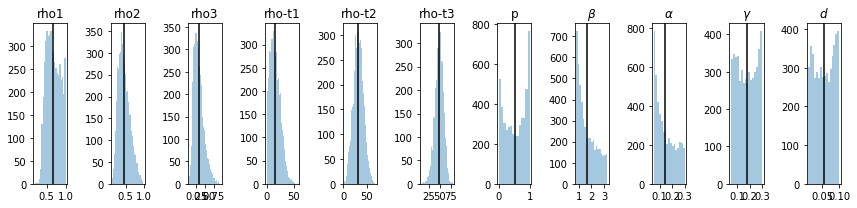

In [5]:
print("Time series length", S.shape[0])

f, axarr = plt.subplots(1, theta_hat.shape[1], figsize=(12, 3))
for i in range(theta_hat.shape[1]):
    
    sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
    axarr[i].axvline(theta_means[i], color='black')

    axarr[i].set_title(param_names[i])
f.tight_layout()

for i in range(theta_hat.shape[1]):
    print(param_names[i],theta_means[i])

Currently, we have the following parameters:

1. $\alpha$ - inverse of incubation period (rate at which exposed move to infected)
2. $\beta$ - average contact rate in the population (I would model this in a more fine-grained manner
3. $\gamma$ - inverse of the mean infectous period (or rate at which infectious move to recovered)
4. $d$ - death rate
5. $\rho$ - social distancing $\in [0, 1]$